## Strategy
How will Strategy module will be used:

It will take a:
- df (the start and the ending date will be provided within the dataframe)
- type of objective function to use ('Sharpe Ratio', 'Multiple', ... any metrics)


It will contain methods:
- that will perform dynamic universe selection
- that will contain the trading strategy (will take the parameters as input)
- that will optimize for the best parameters given the objective function (will call the trading strategy method)\
-> Make sure to enforce the use of discrete parameters (by using an integer space (not real))\
-> Use BayesOptCV (cross validation, not Bayesian Optimization)
- that will perform the walk forward analysis (from sklearn.model_selection import TimeSeriesSplit)

It will output the strategy return column, position, cumulative return, trades, sessions, cumulative session return.


======================================================

Practical Recommendations
Low-Dimensional Problems (<5 dimensions):

init_points: 5–10
n_iter: 10–30
Moderate-Dimensional Problems (5–10 dimensions):

init_points: 10–15
n_iter: 30–50
High-Dimensional Problems (>10 dimensions):

Bayesian optimization might struggle due to the curse of dimensionality. Consider alternatives like random search or evolutionary algorithms if dimensions are very high.

======================================================

The key is to perform separate walk-forward analysis for both the strategies and the rebalancing process

---

In [1]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Data_Management'))) #We have a double .. as we are in the Strategy subfolder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Universe_Selection')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Signal_Generation')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Risk_Management')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Validation')))

# Import the modules
from data import Data
from calculations import Calculations, Metrics
from coarse import Coarse_1 as Coarse
from fine import Fine_1 as Fine
from entry_signal import Trend_Following, Mean_Reversion
from tail_risk import Stop_Loss, Take_Profit
from manage_trade import Manage_Trade
from position import Position
from testing import WFO

Skipping category 'layer-1', already processed.
Skipping category 'depin', already processed.
Skipping category 'proof-of-work-pow', already processed.
Skipping category 'proof-of-stake-pos', already processed.
Skipping category 'meme-token', already processed.
Skipping category 'dog-themed-coins', already processed.
Skipping category 'eth-2-0-staking', already processed.
Skipping category 'non-fungible-tokens-nft', already processed.
Skipping category 'governance', already processed.
Skipping category 'artificial-intelligence', already processed.
Skipping category 'infrastructure', already processed.
Skipping category 'layer-2', already processed.
Skipping category 'zero-knowledge-zk', already processed.
Skipping category 'storage', already processed.
Skipping category 'oracle', already processed.
Skipping category 'bitcoin-fork', already processed.
Skipping category 'restaking', already processed.
Skipping category 'rollup', already processed.
Skipping category 'metaverse', already p

Importing all_data.csv file for all types of data

In [2]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [85]:
start_time = dt.datetime(2024, 1, 1)
end_time = dt.datetime(2024, 3, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

c:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\data.py:87: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level=1)


close  creturns        high  log_return  \
date                coin                                                    
2024-01-01 01:00:00 ADAUSDT      0.6023  1.007359      0.6029    0.007332   
                    BNBUSDT    315.3000  1.002863    316.0000    0.002859   
                    BTCUSDT  42613.5600  1.003257  42775.0000    0.003251   
                    ETHUSDT   2303.7200  1.003577   2306.6000    0.003570   
                    XRPUSDT      0.6185  1.003733      0.6190    0.003726   
...                                 ...       ...         ...         ...   
2024-02-29 23:00:00 ADAUSDT      0.6547  1.094999      0.6606    0.009515   
                    BNBUSDT    399.4000  1.270356    400.7000    0.008044   
                    BTCUSDT  61130.9800  1.439215  61536.9400   -0.001521   
                    ETHUSDT   3340.0900  1.455054   3358.9700    0.005247   
                    XRPUSDT      0.5867  0.952126      0.5898    0.004270   

                                    low        open       price   returns  \
date                coin                                                    
2024-01-01 01:00:00 ADAUSDT      0.5966      0.5979      0.6023  0.007359   
                    BNBUSDT    314.1000    314.3000    315.3000  0.002863   
                    BTCUSDT  42431.6500  42475.2300  42613.5600  0.003257   
                    ETHUSDT   2292.9000   2295.5200   2303.7200  0.003577   
                    XRPUSDT      0.6150      0.6161      0.6185  0.003733   
...                                 ...         ...         ...       ...   
2024-02-29 23:00:00 ADAUSDT      0.6482      0.6485      0.6547  0.009561   
                    BNBUSDT    396.0000    396.3000    399.4000  0.008077   
                    BTCUSDT  60998.5100  61224.0200  61130.9800 -0.001520   
                    ETHUSDT   3319.1800   3322.6000   3340.0900  0.005261   
                    XRPUSDT      0.5841      0.5843      0.5867  0.004279   

                                   volume  volume_in_dollars  
date                coin                                      
2024-01-01 01:00:00 ADAUSDT  2.607607e+06       1.570562e+06  
                    BNBUSDT  1.555812e+04       4.905474e+06  
                    BTCUSDT  1.196379e+03       5.098195e+07  
                    ETHUSDT  8.413426e+03       1.938218e+07  
                    XRPUSDT  9.029149e+06       5.584529e+06  
...                                   ...                ...  
2024-02-29 23:00:00 ADAUSDT  9.134539e+06       5.980383e+06  
                    BNBUSDT  1.887541e+04       7.538840e+06  
                    BTCUSDT  1.694180e+03       1.035669e+08  
                    ETHUSDT  1.463559e+04       4.888418e+07  
                    XRPUSDT  1.859032e+07       1.090694e+07  

[7195 rows x 10 columns]

---

## Dynamic Universe Selection Strategy

current_universe = {}\
max_positions = 4
```pseudocode
for each row:
	for each coin in current_universe:
		If the current position of the coin == 0
			Remove it from current universe

	if len(universe) < max_positions:

		current coins = coins at the current index
		available_coins = current_coins - universe => All coins not in the universe

		filter = above_ema, volume_rank < 50 (could be optimized), std_rank < 4 (should be FINAL Constant),	 entry_signal.shift() == 1
		potential_coins = available coins with applied filter => Potenatial coins that could be added to the universe
		potential_coins = potential_coins.sort(based on std_rank)
	
		missing_positions = max_positions - len(current_universe)
		to_be_added = potential_coins[:missing_positions]

		current_universe = current_universe + to_be_added #Update the current universe

	for each coin in the current row:
		if coin is in universe:
			df[(time, coin), 'in_universe'] = True => mark it as part of the universe

	return df = df[df['in_universe']]

```



In [4]:
def create_test_df(num_times: int = 5, num_coins: int = 10):
    """Creates a multi-index DataFrame for testing."""
    times = pd.to_datetime(['2024-01-01'] + [pd.Timestamp('2024-01-01') + pd.Timedelta(days=i) for i in range(1, num_times)])
    coins = [f"Coin_{i}" for i in range(num_coins)]
    index = pd.MultiIndex.from_product([times, coins], names=['time', 'coin'])
    
    df = pd.DataFrame(index=index)
    df['above_ema'] = np.random.choice([True, False], size=len(df))
    df['volume_rank'] = np.random.randint(1, 100, size=len(df))
    df['std_rank'] = np.random.randint(1, 10, size=len(df))
    df['entry_signal'] = np.random.randint(0, 2, size=len(df)) # 0 or 1
    df['position'] = np.random.randint(0, 2, size=len(df))
    return df

# Example usage to create a test DataFrame:
test_df = create_test_df(num_times=4, num_coins=8)
test_df.head()

above_ema  volume_rank  std_rank  entry_signal  position
time       coin                                                            
2024-01-01 Coin_0      False           12         7             0         0
           Coin_1       True            7         7             1         1
           Coin_2      False           21         3             0         1
           Coin_3      False            2         6             0         0
           Coin_4       True           79         7             1         1

In [5]:
import pandas as pd
import numpy as np
from typing import Set, List
import pandas as pd
from typing import List


def update_universe(df: pd.DataFrame, max_positions: int = 4, low_freq = '1d') -> pd.Series:
    """
    Updates a DataFrame to track a dynamic universe of coins.
    Should include the dataframe with the lower frequency data. (daily, weekly, etc.)
    Assumes a stacked dataframe
    """
    current_universe = set()
    df['in_universe'] = False

    for time_index in df.index.get_level_values(0).unique():
        # Remove coins that are no longer in the universe *for this time index*
        coins_to_remove = []
        for coin in current_universe:
            if (time_index, coin) in df.index and df.loc[(time_index, coin), 'position'] == 0:
                coins_to_remove.append(coin)
                df.loc[(time_index, coin), 'in_universe'] = False
        current_universe.difference_update(coins_to_remove) #use difference_update for set manipulation


        current_coins = df.loc[time_index].index
        available_coins = set(current_coins) - current_universe

        if len(current_universe) < max_positions and available_coins:
            temp_df = df.loc[(time_index, list(available_coins)), :].copy()

            # The shift was the main source of the bug. It was shifting across coins,
            # which is incorrect. We should not shift at all in this context.
            # The intention was likely to use the *previous* time slice data.
            # This is handled later.

            filter_condition = (
                (temp_df['above_ema']) &
                (temp_df['volume_rank'] < 50) &
                (temp_df['std_rank'] < 10) &
                (temp_df['entry_signal'] == 1)
            )

            potential_coins_df = temp_df[filter_condition]

            if not potential_coins_df.empty:
                potential_coins_df = potential_coins_df.sort_values(by='std_rank')
                potential_coins = set(potential_coins_df.index.get_level_values(1))
                missing_positions = max_positions - len(current_universe)
                to_be_added: List[str] = list(potential_coins)[:missing_positions]
                current_universe.update(to_be_added)

        df.loc[(time_index, list(current_universe)), 'in_universe'] = True
    
    df = df.unstack()
    df['in_universe'] = df['in_universe'].shift(periods = 1, freq = low_freq)
    df = df.stack()
    return df['in_universe'], current_universe

test_df['in_universe'], current_universe = update_universe(test_df)

print(current_universe)
test_df

C:\Users\yassi\AppData\Local\Temp\ipykernel_23712\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


{'Coin_0'}


above_ema  volume_rank  std_rank  entry_signal  position  \
time       coin                                                               
2024-01-01 Coin_0      False           12         7             0         0   
           Coin_1       True            7         7             1         1   
           Coin_2      False           21         3             0         1   
           Coin_3      False            2         6             0         0   
           Coin_4       True           79         7             1         1   
           Coin_5      False           43         7             1         1   
           Coin_6       True           23         4             1         0   
           Coin_7       True           55         9             1         0   
2024-01-02 Coin_0      False           45         6             0         0   
           Coin_1       True           39         8             0         0   
           Coin_2       True            7         1             0         0   
           Coin_3       True           91         9             0         0   
           Coin_4      False           12         9             0         1   
           Coin_5       True           81         8             1         0   
           Coin_6       True           12         4             0         0   
           Coin_7      False           38         1             0         0   
2024-01-03 Coin_0      False           76         1             0         0   
           Coin_1      False           50         3             0         0   
           Coin_2       True           78         8             1         0   
           Coin_3      False           53         6             0         1   
           Coin_4       True           60         1             0         1   
           Coin_5       True           55         2             0         1   
           Coin_6       True           13         1             0         1   
           Coin_7      False           77         2             1         1   
2024-01-04 Coin_0       True           22         6             1         0   
           Coin_1       True           65         4             1         1   
           Coin_2       True           64         8             0         1   
           Coin_3       True            1         6             0         0   
           Coin_4       True           24         8             0         1   
           Coin_5       True           25         5             0         0   
           Coin_6      False            8         3             1         1   
           Coin_7      False           66         1             0         1   

                  in_universe  
time       coin                
2024-01-01 Coin_0         NaN  
           Coin_1         NaN  
           Coin_2         NaN  
           Coin_3         NaN  
           Coin_4         NaN  
           Coin_5         NaN  
           Coin_6         NaN  
           Coin_7         NaN  
2024-01-02 Coin_0       False  
           Coin_1        True  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6        True  
           Coin_7       False  
2024-01-03 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False  
2024-01-04 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False

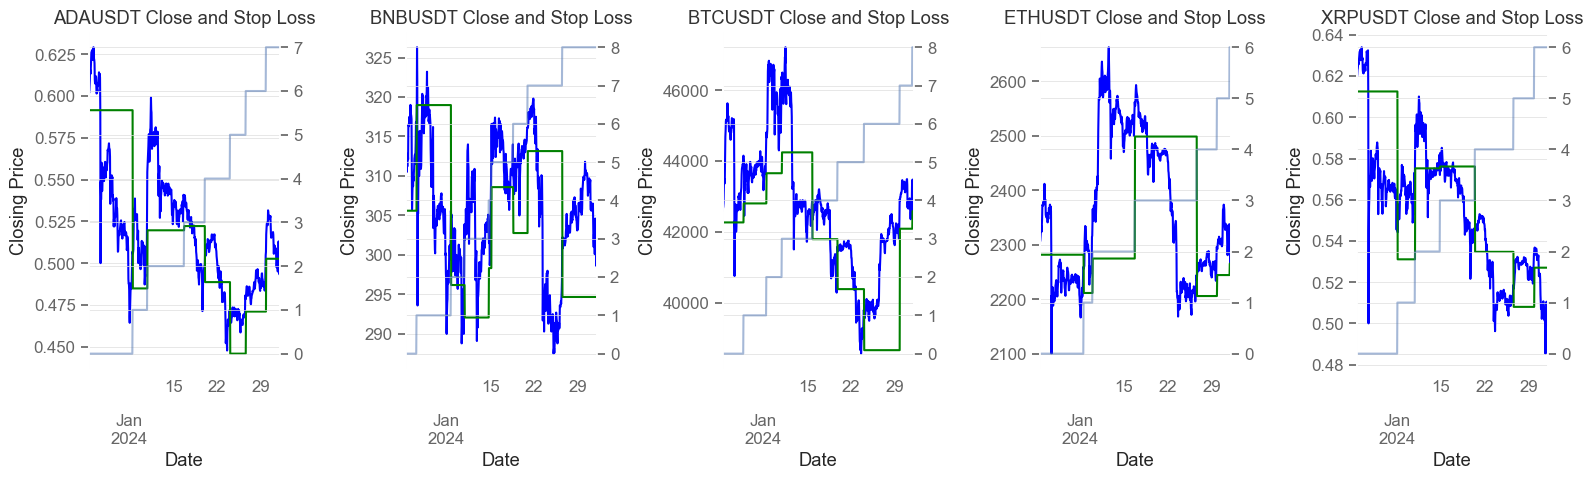

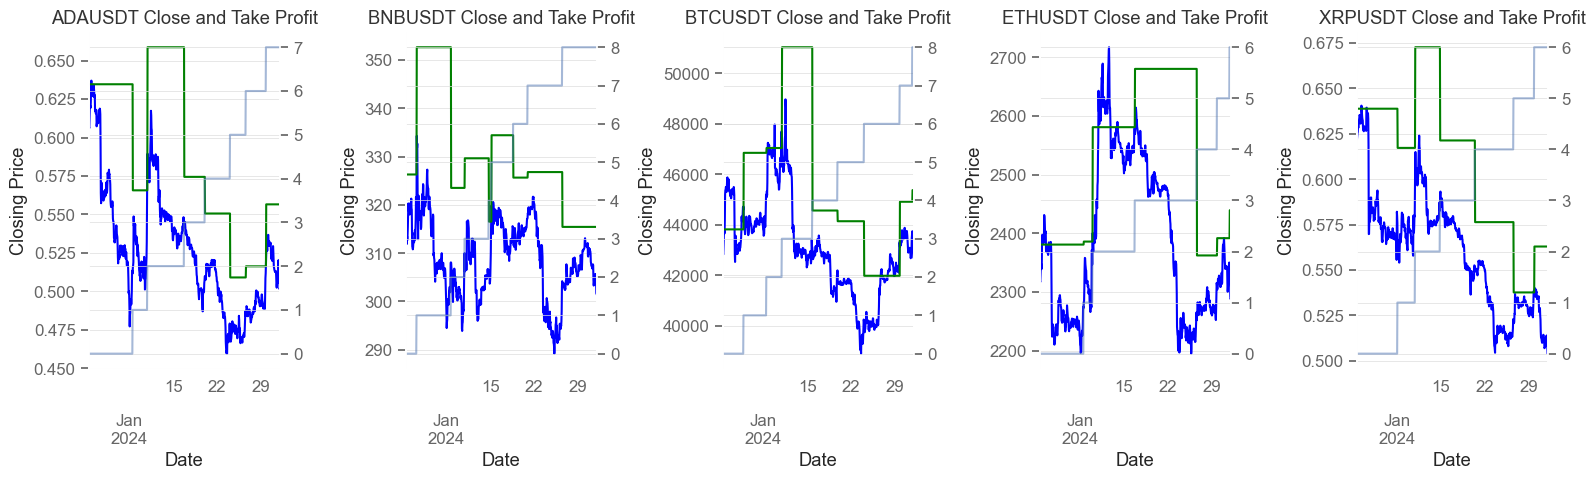

In [6]:
###### To Optimize ######
#All parameters:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling
low_freq_index = 1 #The index of the lowest frequency for the resampling
low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
max_dollar_allocation = 10000
std_window = 2
mean_window = 2
ema_window = 2
high_freq_index = 3 #The index of the highest frequency for the resampling
high_freq = all_frequency[high_freq_index] #The highest frequency for the resampling
str_length = 10
str_mult = 3
_min_pos = 0
_max_pos = 1
sl_type = 'atr'
sl_ind_length = 14
sl_ind_mult = 3
sl_signal_only = True
fixed_sl = True
tp_type = 'rr'
tp_mult = 2
tp_ind_length = 0
tp_signal_only = True
fixed_tp = True
max_perc_risk = 0.01




#Downsample the data
cal = Calculations()
#Generate a signal
tf = Trend_Following()

_df = tf.supertrend_signals(data, str_length, str_mult)

pos = Position(_df, _min_pos, _max_pos)
_df = pos.initialize_position()
sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
_df = sl.apply_stop_loss(fixed_sl, plot = True)
tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
_df = tp.apply_take_profit(fixed_tp, plot = True)

_df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
_df = pos.calculate_position(_df)

mt = Manage_Trade(_df)
_df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

#########################

_df = cal.update_all(_df)



In [7]:
_df['position']

date                        
2024-01-01 15:00:00  ADAUSDT    NaN
                     BNBUSDT    NaN
                     BTCUSDT    NaN
                     ETHUSDT    NaN
                     XRPUSDT    NaN
                               ... 
2024-01-31 23:00:00  ADAUSDT    0.0
                     BNBUSDT    1.0
                     BTCUSDT    0.0
                     ETHUSDT    0.0
                     XRPUSDT    0.0
Name: position, Length: 3645, dtype: float64

In [8]:
df = cal.downsample(_df, low_freq)

#Perform coarse analysis and filtering
coarse = Coarse()
df = coarse.volume_flag(df, max_dollar_allocation)
df = coarse.sort_by_volume(df)
df = coarse.sort_by_std(df, std_window, mean_window)
fine = Fine()
df = fine.above_ema(df, ema_window)

#apply update_univers
df['in_universe'], current_universe = update_universe(df)

C:\Users\yassi\AppData\Local\Temp\ipykernel_23712\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [9]:
df.dropna()

close  creturns        high  log_return  \
date                                                                        
2024-01-02 15:00:00 BNBUSDT    308.4000  0.980916    313.4000   -0.011606   
                    ETHUSDT   2357.4800  1.026996   2371.1400   -0.004148   
2024-01-02 16:00:00 BNBUSDT    310.8000  0.988550    311.3000    0.007752   
                    ETHUSDT   2367.9100  1.031540   2369.6000    0.004414   
2024-01-02 17:00:00 BNBUSDT    310.2000  0.986641    311.2000   -0.001932   
...                                 ...       ...         ...         ...   
2024-01-31 23:00:00 ADAUSDT      0.4976  0.832246      0.5023   -0.004812   
                    BNBUSDT    300.5000  0.955789    301.4000   -0.002659   
                    BTCUSDT  42580.0000  1.002467  42688.8800   -0.001785   
                    ETHUSDT   2283.1400  0.994611   2288.9100   -0.001143   
                    XRPUSDT      0.5033  0.816780      0.5040    0.002387   

                                    low        open       price   returns  \
date                                                                        
2024-01-02 15:00:00 BNBUSDT    305.8000    312.0000    308.4000 -0.011538   
                    ETHUSDT   2352.0400   2367.2700   2357.4800 -0.004140   
2024-01-02 16:00:00 BNBUSDT    307.5000    308.5000    310.8000  0.007782   
                    ETHUSDT   2350.1900   2357.4800   2367.9100  0.004424   
2024-01-02 17:00:00 BNBUSDT    308.7000    310.8000    310.2000 -0.001931   
...                                 ...         ...         ...       ...   
2024-01-31 23:00:00 ADAUSDT      0.4975      0.4999      0.4976 -0.004800   
                    BNBUSDT    299.9000    301.3000    300.5000 -0.002655   
                    BTCUSDT  42555.4600  42656.0700  42580.0000 -0.001783   
                    ETHUSDT   2281.8800   2285.7500   2283.1400 -0.001142   
                    XRPUSDT      0.5015      0.5021      0.5033  0.002390   

                                   volume  volume_in_dollars  ...   htf_close  \
date                                                          ...               
2024-01-02 15:00:00 BNBUSDT  1.186873e+05       3.660317e+07  ...    312.2000   
                    ETHUSDT  2.561761e+04       6.039301e+07  ...   2355.3400   
2024-01-02 16:00:00 BNBUSDT  5.781969e+04       1.797036e+07  ...    312.2000   
                    ETHUSDT  1.891655e+04       4.479269e+07  ...   2355.3400   
2024-01-02 17:00:00 BNBUSDT  4.304223e+04       1.335170e+07  ...    312.2000   
...                                   ...                ...  ...         ...   
2024-01-31 23:00:00 ADAUSDT  3.184728e+06       1.584721e+06  ...      0.4976   
                    BNBUSDT  1.395899e+04       4.194675e+06  ...    300.5000   
                    BTCUSDT  1.257928e+03       5.356257e+07  ...  42580.0000   
                    ETHUSDT  9.636504e+03       2.200149e+07  ...   2283.1400   
                    XRPUSDT  6.818038e+06       3.431519e+06  ...      0.5033   

                               htf_volume  htf_volume_in_dollars  volume_flag  \
date                                                                            
2024-01-02 15:00:00 BNBUSDT  9.377647e+05           2.950305e+08            1   
                    ETHUSDT  4.580417e+05           1.091562e+09            1   
2024-01-02 16:00:00 BNBUSDT  9.377647e+05           2.950305e+08            1   
                    ETHUSDT  4.580417e+05           1.091562e+09            1   
2024-01-02 17:00:00 BNBUSDT  9.377647e+05           2.950305e+08            1   
...                                   ...                    ...          ...   
2024-01-31 23:00:00 ADAUSDT  1.329996e+08           6.751623e+07            1   
                    BNBUSDT  4.590077e+05           1.394739e+08            1   
                    BTCUSDT  3.987114e+04           1.711216e+09            1   
                    ETHUSDT  3.971162e+05           9.200687e+08            1   
    

<Axes: xlabel='date,None'>

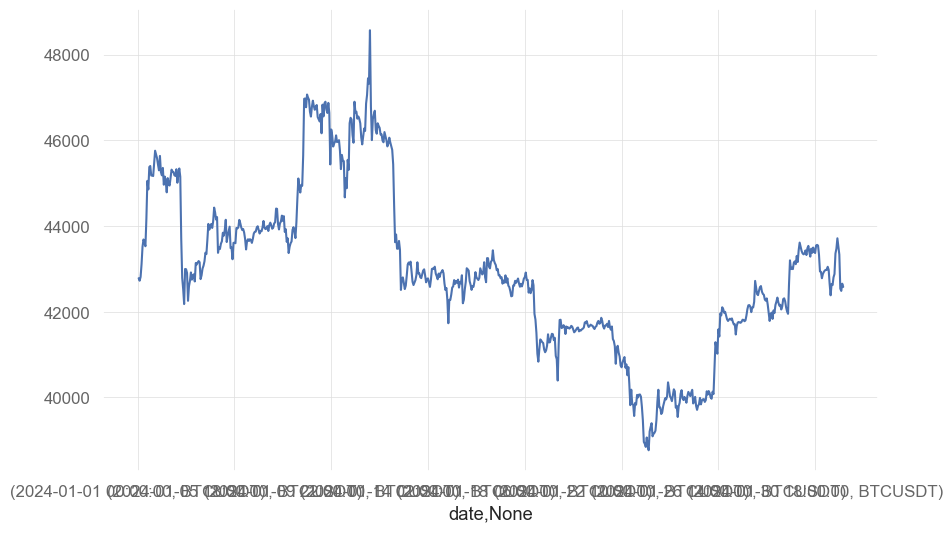

In [10]:
df.loc[(slice(None), 'BTCUSDT'), 'close'].plot()


In [11]:
df.dropna(inplace = True)

In [12]:
df = df[df['in_universe']]

#### Trading Strategy

In [13]:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling 

In [98]:
def trading_strategy(
        data,
        params = None,
        ###### To Optimize ######
        std_window = 20,
        mean_window = 20,
        ema_window = 20,
        str_length = 10,
        str_mult = 3,
        _min_pos = 0, #Has to be >= 0
        _max_pos = 1, #Has to be > 0
        sl_ind_length = 14,
        sl_ind_mult = 3,
        tp_mult = 2,
        ptp_mult = 1,
        ###### Constants ######
        low_freq_index = 1, #The index of the lowest frequency for the resampling
        high_freq_index = 3, #The index of the highest frequency for the resampling
        max_perc_risk = 0.01,
        max_dollar_allocation = 10000,
        sl_type = 'atr',
        tp_type = 'rr',
        sl_signal_only = True,
        tp_signal_only = True,
        ptp_signal_only = True,
        tp_ind_length = 0,
        fixed_sl = True,
        fixed_tp = True
        ):
    
    if params is not None:
        if isinstance(params, list):
            std_window = params[0]
            mean_window = params[1]
            ema_window = params[2]
            str_length = params[3]
            str_mult = params[4]
            _min_pos = params[5]
            _max_pos = params[6]
            sl_ind_length = params[7]
            sl_ind_mult = params[8]
            tp_mult = params[9]
            ptp_mult = params[10]
        if isinstance(params, dict):
            std_window = params['std_window']
            mean_window = params['mean_window']
            ema_window = params['ema_window']
            str_length = params['str_length']
            str_mult = params['str_mult']
            _min_pos = params['_min_pos']
            _max_pos = params['_max_pos']
            sl_ind_length = params['sl_ind_length']
            sl_ind_mult = params['sl_ind_mult']
            tp_mult = params['tp_mult']
            ptp_mult = params['ptp_mult']
        


    if high_freq_index > low_freq_index:
        low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
        high_freq = all_frequency[high_freq_index], #The highest frequency for the resampling
            #Generally not going to be used since we are not calling the data inside the function
    
    #Downsample the data
    cal = Calculations()
    #Generate a signal
    tf = Trend_Following()

    _df = tf.supertrend_signals(data.copy(), str_length, str_mult)

    pos = Position(_df, _min_pos, _max_pos)
    _df = pos.initialize_position()
    sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
    _df = sl.apply_stop_loss(fixed_sl, plot = False)
    tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
    _df = tp.apply_take_profit(fixed_tp, plot = False)
    ptp = Take_Profit(_df, tp_type, ptp_mult, ptp_signal_only)
    _df = ptp.apply_take_profit(fixed_tp, plot = False)

    _df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
    _df = pos.calculate_position(_df)

    mt = Manage_Trade(_df)
    _df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

    #########################

    _df = cal.update_all(_df)

    df = cal.downsample(_df, low_freq)

    #Perform coarse analysis and filtering
    coarse = Coarse()
    df = coarse.volume_flag(df, max_dollar_allocation)
    df = coarse.sort_by_volume(df)
    df = coarse.sort_by_std(df, std_window, mean_window)
    fine = Fine()
    df = fine.above_ema(df, ema_window)

    #apply update_univers
    df['in_universe'], current_universe = update_universe(df)

    df.dropna(inplace = True)

    df = df[df['in_universe']]

    return df



In [15]:
sample_strategy = trading_strategy(data)
'strategy' in sample_strategy.columns

C:\Users\yassi\AppData\Local\Temp\ipykernel_23712\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


True

In [123]:
# Define parameter space for optimization
param_space = {
    'std_window': Integer(5, 30),
    'mean_window': Integer(5, 30),
    'ema_window': Integer(5, 100),
    'str_length': Integer(5, 50),
    'str_mult': Integer(1, 5),
    '_min_pos': Real(0, 1),
    '_max_pos': Real(1, 5),
    'sl_ind_length': Integer(5, 50),
    'sl_ind_mult': Real(0.5, 5),
    'tp_mult': Integer(2, 7),
    'ptp_mult': Real(1, 2)
}

In [119]:
wfo = WFO(data, trading_strategy, param_space, train_size = 1500, test_size=1500, step_size=500, optimize_fn="gp", objective = 'sharpe')

C:\Users\yassi\AppData\Local\Temp\ipykernel_23712\3841925515.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [ ]:
results = wfo.walk_forward_optimization()

In [121]:
results

[0.9274809160305328,
 0.8698474521259317,
 0.8234339500162264,
 1.033905319515053,
 1.0927506305788248,
 1.2322272610443865,
 0.9070107108081763,
 0.8747160012982764,
 1.4510195991304746]